# Project 3: Web APIs & NLP
---
Book 1: Data Collection<br>
**Book 2: Data Cleaning & Exploratory Data Analysis**<br>
Book 3: Preprocessing & Vectorization<br>
Book 4: ML Modeling<br>
Book 5: Sentiment Analysis, Conclusion & Recommendation<br>
Author: Lee Wan Xian

## Contents:
- [Dataset Information](#Dataset-Information)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

## Dataset Information

### Datasets used

There is 1 dataset in the `data` folder, which was scraped from Reddit earlier in Book 1.

* [`df_raw.csv`](../data/df_raw.csv): Contains posts from the subreddits `r/DisneyPlus` and `r/netflix`, starting from 30 Sep 2022 and earlier.

### Data dictionary

Parameter|Datatype|Description
---|---|---
subreddit|String|The subreddit where the post was scraped from
title|String|Title of the post
selftext|String|Body of the post
is_video|Boolean|True: The post contains video content<br>False: The post does not contain video content
created_utc|Integer|Unix epoch time of when the post was created

## Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

In [2]:
# this setting widens pandas column to fit 400 characters
pd.options.display.max_colwidth = 400

## Data Cleaning

### Import raw data corpus

In [3]:
# Import the raw corpus from data folder
df_raw = pd.read_csv('../data/df_raw.csv')

In [4]:
print(df_raw.shape)
df_raw.info()
df_raw.head()

(29970, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29970 entries, 0 to 29969
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    29970 non-null  object
 1   title        29970 non-null  object
 2   selftext     18221 non-null  object
 3   is_video     29970 non-null  bool  
 4   created_utc  29970 non-null  int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 966.0+ KB


,subreddit,title,selftext,is_video,created_utc
0,DisneyPlus,willow.... thought you were to be released today?,[removed],False,1664581822
1,DisneyPlus,Who’s excited?!,[removed],False,1664580125
2,DisneyPlus,"Hocus Pocus 2 was a let down, thoughts?",[removed],False,1664579363
3,DisneyPlus,Friend made Hocus Pocus cookies!,NaN,False,1664578323
4,DisneyPlus,Hocus Pocus 2 - Movie Discussion Thread,As there wasn't one already thought I'd create one.,False,1664575672


### Cleaning data corpus

In [5]:
# Check for duplicated documents
df_raw.duplicated().value_counts()

False    29831
True       139
dtype: int64

Since 139 out of 29970 data observations, which is around 0.46%, are duplicates, we can drop these duplicates from the corpus. That way, there would be less noise being fed into our model later.

In [6]:
# Drop duplicates from df_raw
df_raw.drop_duplicates(inplace=True)

In [7]:
# Check for missing values
df_raw.isna().sum().sort_values(ascending=False)

selftext       11743
subreddit          0
title              0
is_video           0
created_utc        0
dtype: int64

It is reasonable for `selftext` field to be empty as Reddit allows users to make a post without a text body, provided they post images or video instead ([source](https://reddit.zendesk.com/hc/en-us/articles/360060422572-How-do-I-post-on-Reddit-)). Thus, it is fine to retain the data documents with empty `selftext` and manage it with feature engineering later.

## Exploratory Data Analysis

In [8]:
# Create a data corpus copy for EDA
df_eda = df_raw

In [9]:
# Summary Stats
df_eda.describe(include='all')

,subreddit,title,selftext,is_video,created_utc
count,29831,29831,18088,29831,2.983100e+04
unique,2,28394,9775,2,NaN
top,DisneyPlus,Check out this story I saved on Pocket,[removed],False,NaN
freq,14976,157,8028,29496,NaN
mean,NaN,NaN,NaN,NaN,1.645112e+09
std,NaN,NaN,NaN,NaN,1.380033e+07
min,NaN,NaN,NaN,NaN,1.614041e+09
25%,NaN,NaN,NaN,NaN,1.636773e+09
50%,NaN,NaN,NaN,NaN,1.647737e+09
75%,NaN,NaN,NaN,NaN,1.656175e+09


### Frequency of posts created in both subreddits

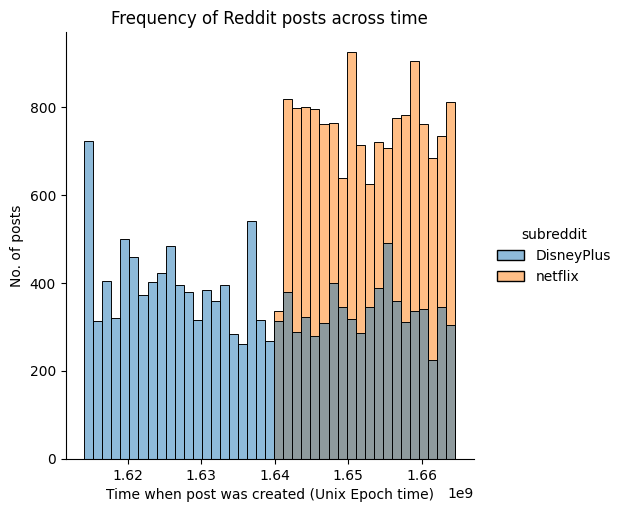

In [9]:
# Plot the frequency of posts created across time

sns.displot(data=df_eda,
            x='created_utc',
            hue='subreddit');

plt.xlabel('Time when post was created (Unix Epoch time)')
plt.ylabel('No. of posts')
plt.title('Frequency of Reddit posts across time')
plt.show()

It seems that `r/netflix` is more active than `r/DisneyPlus`. The frequency of posts created in Netflix subreddit is about twice as much as DisneyPlus subreddit. Based on the webscraping logic in Book 1, we were able to extract about 15,000 posts to Unix Epoch 1640720030 timemark for Netflix subreddit. As for DisneyPlus subreddit, we had to extract posts all the way to Unix Epoch time 1614041482, where the time period is about twice as long as that of Netflix subreddit.

### Correlation between posts without text body and posts with video content

In [10]:
# Show how many posts have video or not, given that the post has no text body
df_eda.loc[df_eda['selftext'].isna(),['is_video']].value_counts()

is_video
False       11414
True          329
dtype: int64

In [11]:
# Show how many posts have video or not, given that the post has text body
df_eda.loc[df_eda['selftext'].notna(),['is_video']].value_counts()

is_video
False       18082
True            6
dtype: int64

In [12]:
# Create a new column to indicate posts having text in their body.
# This would help when plotting the relationship between video posts & text body posts

df_eda['text_in_body'] = ['no' if x is np.NaN else 'yes' for x in df_eda['selftext']]
df_eda.head()

,subreddit,title,selftext,is_video,created_utc,text_in_body
0,DisneyPlus,willow.... thought you were to be released today?,[removed],False,1664581822,yes
1,DisneyPlus,Who’s excited?!,[removed],False,1664580125,yes
2,DisneyPlus,"Hocus Pocus 2 was a let down, thoughts?",[removed],False,1664579363,yes
3,DisneyPlus,Friend made Hocus Pocus cookies!,NaN,False,1664578323,no
4,DisneyPlus,Hocus Pocus 2 - Movie Discussion Thread,As there wasn't one already thought I'd create one.,False,1664575672,yes


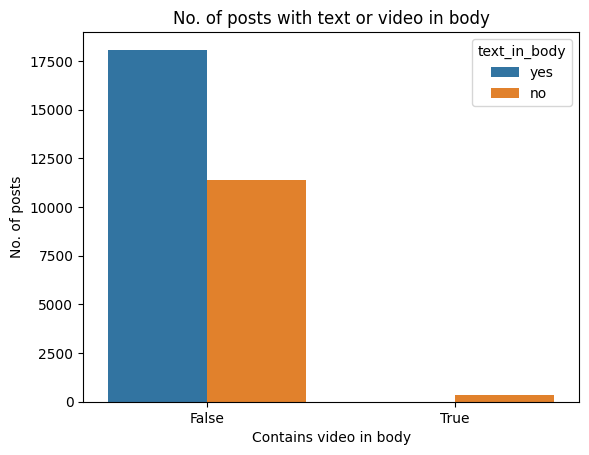

In [13]:
# Historgram of posts (with vs without video & with vs without text)

sns.countplot(data=df_eda,
              x='is_video',
              hue='text_in_body');

plt.xlabel('Contains video in body')
plt.ylabel('No. of posts')
plt.title('No. of posts with text or video in body');
plt.show();

Compared to the full corpus, there is a very small number of posts that contain videos.<br>
For posts that contain video content, it is highly likely that they do not contain any text in the body. Only 6 posts have both text and video content in the body while the remaining 329 video posts have no text in body. As for the posts that neither have text nor video in the body, we can infer that such posts are related to weblinks or images to a strong extent.

### Word count in `title`

For the purpose of EDA, we will assume that all words are separated by whitespaces only.

In [14]:
# Create a new column for word count in title
df_eda['title_word_count'] = [len(x.split()) for x in df_eda['title'].tolist()]

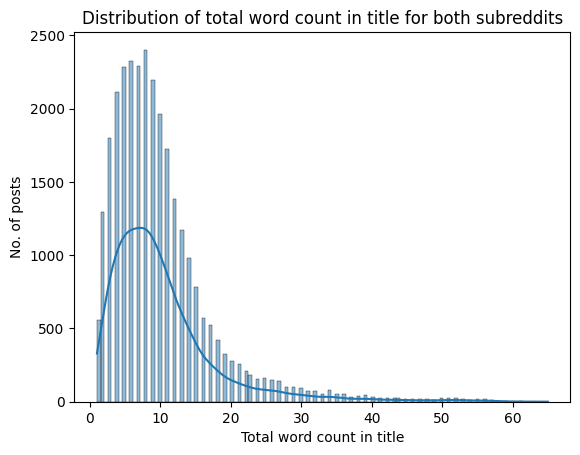

In [15]:
# Distribution of title by word count

sns.histplot(data=df_eda,
             x='title_word_count',
             kde=True);

plt.xlabel('Total word count in title')
plt.ylabel('No. of posts')
plt.title('Distribution of total word count in title for both subreddits')
plt.show();

The distribution of total word count in title is skewed to the right and most posts rarely exceed 20 words in the title.

#### Top common words from post title in DisneyPlus subreddit

We will instantiate stopwords list from NLTK corpus ([source](https://www.nltk.org/nltk_data/)) to remove stop words that do not provide key insights into the subreddit corpus.

In [16]:
# Split the data corpus based on subreddit
df_eda_disney = df_eda[df_eda['subreddit'] == 'DisneyPlus']
df_eda_netflix = df_eda[df_eda['subreddit'] == 'netflix']

**Using Count Vectorizer - Unigram**

In [17]:
# Instantiate stopwords from nltk.corpus
nltk_stopwords = stopwords.words('english')

In [18]:
# Instantiate Count Vectorizers & TF-IDF Vectorizers
cvec = CountVectorizer(stop_words = nltk_stopwords)
cvec_bi = CountVectorizer(stop_words = nltk_stopwords, ngram_range = (2, 2))

tfvec = TfidfVectorizer(stop_words = nltk_stopwords)
tfvec_bi = TfidfVectorizer(stop_words = nltk_stopwords, ngram_range = (2, 2))

In [19]:
# Count Vectorize the document in title of Disneyplus posts

disney_cvec = pd.DataFrame(data = cvec.fit_transform(df_eda_disney['title']).todense(),
                           columns = cvec.get_feature_names()
                          )

In [20]:
# Show the total count of unique words in the title of Disneyplus corpus

print(f'Total count of unique words in DisneyPlus corpus: {len(disney_cvec.columns)}')

Total count of unique words in DisneyPlus corpus: 10313


In [21]:
# Show the top 25 words in Disney corpus

disney_word_count = disney_cvec.sum().sort_values(ascending=False)
disney_top_count = disney_word_count[:25]

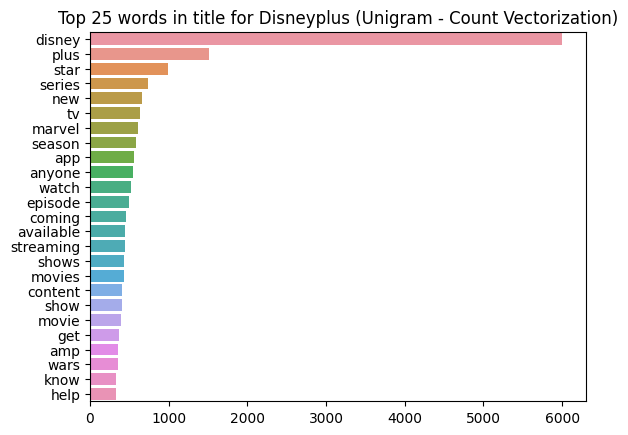

In [22]:
# Bar chart on the top 25 words in title for Disney corpus

sns.barplot(x = disney_top_count.values,
            y = disney_top_count.index);

plt.title('Top 25 words in title for Disneyplus (Unigram - Count Vectorization)')
plt.show();

**Using TF-IDF Vectorizer - Unigram**

In [23]:
# TF-IDF Vectorize the document in the title of Disneyplus posts

disney_tfvec = pd.DataFrame(data = tfvec.fit_transform(df_eda_disney['title']).todense(),
                            columns = tfvec.get_feature_names()
                           )

In [24]:
# Show the total count of unique words in the title of Disneyplus corpus
print(f'Total count of unique words in DisneyPlus corpus: {len(disney_tfvec.columns)}')

Total count of unique words in DisneyPlus corpus: 10313


In [25]:
# Show the top 25 words in Disney corpus

disney_word_tfcount = disney_tfvec.sum().sort_values(ascending=False)
disney_top_tfcount = disney_word_tfcount[:25]

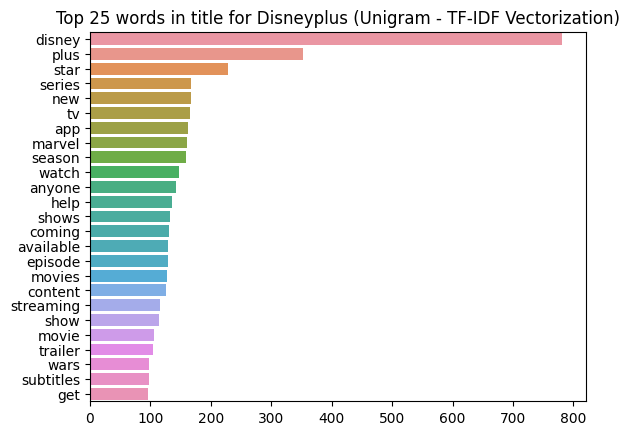

In [26]:
# Bar chart on the top 25 words in Disney

sns.barplot(x = disney_top_tfcount.values,
            y = disney_top_tfcount.index);

plt.title('Top 25 words in title for Disneyplus (Unigram - TF-IDF Vectorization)')
plt.show();

**Using Count Vectorizer - Bigram**

In [27]:
# Count Vectorize the document in the title of Disneyplus posts

disney_cvec = pd.DataFrame(data = cvec_bi.fit_transform(df_eda_disney['title']).todense(),
                           columns = cvec_bi.get_feature_names()
                          )

In [28]:
# Show the top 25 bigram words in Disney corpus

disney_word_count = disney_cvec.sum().sort_values(ascending=False)
disney_top_count = disney_word_count[:25]

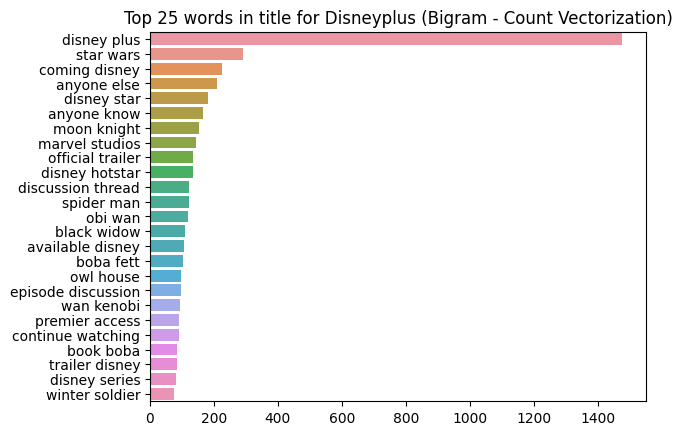

In [29]:
# Bar chart on the top 25 bigram words in Disney

sns.barplot(x = disney_top_count.values,
            y = disney_top_count.index);

plt.title('Top 25 words in title for Disneyplus (Bigram - Count Vectorization)')
plt.show();

**Using TF-IDF Vectorizer - Bigram**

In [30]:
# Count Vectorize the document in the title of Disneyplus posts

disney_tfvec = pd.DataFrame(data = tfvec_bi.fit_transform(df_eda_disney['title']).todense(),
                            columns = tfvec_bi.get_feature_names()
                           )

In [31]:
# Show the top 25 bigram words in Disney corpus

disney_word_tfcount = disney_tfvec.sum().sort_values(ascending=False)
disney_top_tfcount = disney_word_tfcount[:25]

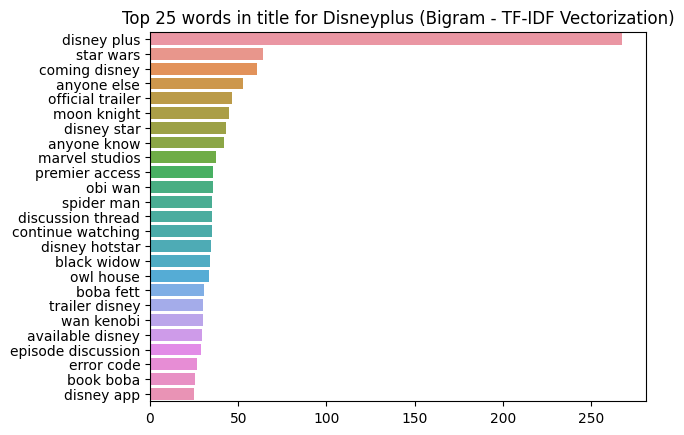

In [32]:
# Bar chart on the top 25 bigram words in Disney

sns.barplot(x = disney_top_tfcount.values,
            y = disney_top_tfcount.index);

plt.title('Top 25 words in title for Disneyplus (Bigram - TF-IDF Vectorization)')
plt.show();

#### Top common words from title of posts in Netflix subreddit

**Using Count Vectorizer - Unigram**

In [33]:
# Count Vectorize the document in the title of Netflix posts

netflix_cvec = pd.DataFrame(data = cvec.fit_transform(df_eda_netflix['title']).todense(),
                            columns = cvec.get_feature_names()
                           )

In [34]:
# Show the total count of unique words in the title of Netflix corpus

print(f'Total count of unique words in Netflix corpus: {len(netflix_cvec.columns)}')

Total count of unique words in Netflix corpus: 12434


In [35]:
# Show the top 25 words in Netflix corpus

netflix_word_count = netflix_cvec.sum().sort_values(ascending=False)
netflix_top_count = netflix_word_count[:25]

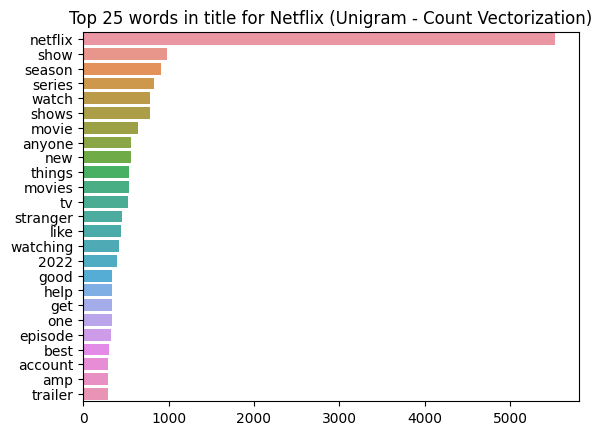

In [36]:
# Bar chart on the top 25 words in Netflix

sns.barplot(x = netflix_top_count.values,
            y = netflix_top_count.index);

plt.title('Top 25 words in title for Netflix (Unigram - Count Vectorization)')
plt.show();

**Using TF-IDF Vectorizer - Unigram**

In [37]:
# TF-IDF Vectorize the document in the title of Netflix posts

netflix_tfvec = pd.DataFrame(data = tfvec.fit_transform(df_eda_netflix['title']).todense(),
                             columns = tfvec.get_feature_names()
                            )

In [38]:
# Show the total count of unique words in the title of Netflix corpus

print(f'Total count of unique words in Netflix corpus: {len(netflix_tfvec.columns)}')

Total count of unique words in Netflix corpus: 12434


In [39]:
# Show the top 25 words in Netflix corpus

netflix_word_tfcount = netflix_tfvec.sum().sort_values(ascending=False)
netflix_top_tfcount = netflix_word_tfcount[:25]

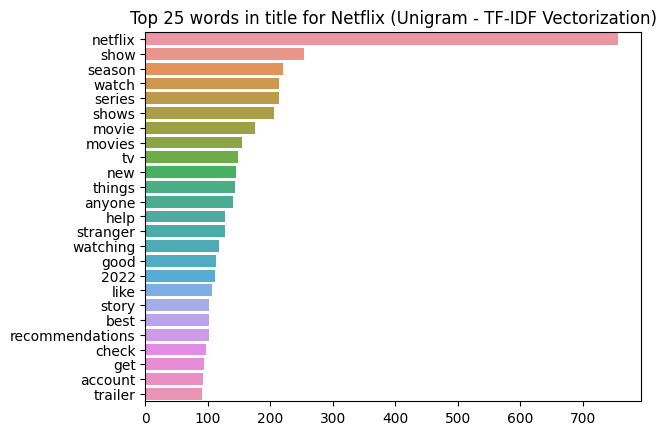

In [40]:
# Bar chart on the top 25 words in Disney

sns.barplot(x = netflix_top_tfcount.values,
            y = netflix_top_tfcount.index);

plt.title('Top 25 words in title for Netflix (Unigram - TF-IDF Vectorization)')
plt.show();

**Using Count Vectorizer - Bigram**

In [41]:
# Count Vectorize the document in the title of Netflix posts

netflix_cvec = pd.DataFrame(data = cvec_bi.fit_transform(df_eda_netflix['title']).todense(),
                            columns = cvec_bi.get_feature_names()
                           )

In [42]:
# Show the top 25 bigram words in Netflix corpus

netflix_word_count = netflix_cvec.sum().sort_values(ascending=False)
netflix_top_count = netflix_word_count[:25]

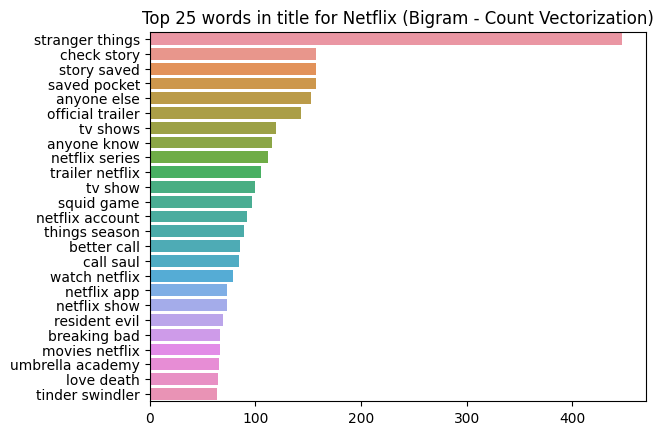

In [43]:
# Bar chart on the top 25 bigram words in Netflix

sns.barplot(x = netflix_top_count.values,
            y = netflix_top_count.index);

plt.title('Top 25 words in title for Netflix (Bigram - Count Vectorization)')
plt.show();

**Using TF-IDF Vectorizer - Bigram**

In [44]:
# Count Vectorize the document in the title of Netflix posts

netflix_tfvec = pd.DataFrame(data = tfvec_bi.fit_transform(df_eda_netflix['title']).todense(),
                             columns = tfvec_bi.get_feature_names()
                            )

In [45]:
# Show the top 25 bigram words in Netflix corpus

netflix_word_tfcount = netflix_tfvec.sum().sort_values(ascending=False)
netflix_top_tfcount = netflix_word_tfcount[:25]

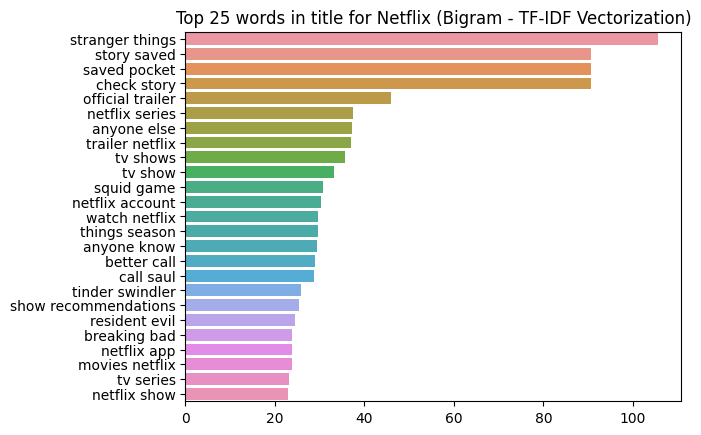

In [46]:
# Bar chart on the top 25 bigram words in Netflix

sns.barplot(x = netflix_top_tfcount.values,
            y = netflix_top_tfcount.index);

plt.title('Top 25 words in title for Netflix (Bigram - TF-IDF Vectorization)')
plt.show();

### Summary of EDA

There are 10313 unique words in DisneyPlus title corpus and 12434 unique words in Netflix title corpus. Most of the posts' title rarely exceeds 20 words. It can be inferred that users usually type long form of text in the body, rather than typing in the title.<br>

Based on the frequency of posts, `r/netflix` is more active than `r/DisneyPlus`. Common words in both corpus are words used to describe shows like `series`, `season`, `episodes` and digital streaming services like `streaming`, `account`, `app`.<br>

For DisneyPlus's title corpus, the top common bigram words include `disney plus`, `star wars`, `black widow`, `moon knight`. For both unigram words and bigram words, there is no significant difference between Count Vectorization and TF-IDF Vectorization, other than the frequency magnitude of words.
For Netflix's title corpus, the top common bigram words include `stranger things`, `official trailer`, `squid game`, `netflix series`. For both unigram words and bigram words, there is no significant difference between Count Vectorization and TF-IDF Vectorization, other than the frequency magnitude of words. Show names that appeared in the top 25 words charts depict that they are one of the most discussed shows in their respective subreddits.

**Please proceed to Book 3 for Preprocessing & Vectorization**